In [10]:
from langchain_community.document_loaders import PyPDFLoader

pdf_file_path = './income_tax.pdf'
loader = PyPDFLoader(pdf_file_path)
pages = []

async for page in loader.alazy_load():
    pages.append(page)

In [11]:
from dotenv import load_dotenv

load_dotenv()

True

In [12]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
from pyzerox import zerox
import os
import asyncio

os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"
kwargs = {}
custom_system_prompt = None
model = "gpt-4o"

async def main():
    file_path = "./income_tax.pdf"
    select_pages = None
    output_dir = "./documents"
    
    result = await zerox(file_path=file_path, 
                         model=model, 
                         output_dir=output_dir,
                         custom_system_prompt=custom_system_prompt, 
                         select_pages=select_pages, 
                         **kwargs)
    return result

result = asyncio.run(main())

print(result)

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 100,
    separators = ['\n\n', '\n']
)

In [10]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_core.documents import Document

#markdown_path = "./documents/income_tax.md"
markdown_path = "./documents/real_estate_tax.md"
loader = UnstructuredMarkdownLoader(markdown_path)
document_list = loader.load_and_split(text_splitter)


In [11]:
import markdown
from bs4 import BeautifulSoup

text_path = "./documents/real_estate_tax.txt"

with open(markdown_path, 'r', encoding='utf-8') as md_file:
    md_content = md_file.read()
    
html_content = markdown.markdown(md_content)

soup = BeautifulSoup(html_content, 'html.parser')
text_content = soup.get_text()

with open(text_path, 'w', encoding='utf-8') as txt_file:
    txt_file.write(text_content)


In [12]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader(text_path)
document_list = loader.load_and_split(text_splitter)

In [13]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

In [14]:
from langchain_chroma import Chroma

# vector_store = Chroma.from_documents(
#     documents=document_list,
#     embedding=embeddings,
#     collection_name='income_tax_collection2',
#     persist_directory='./income_tax_collection2'
# )

vector_store = Chroma.from_documents(
    documents=document_list,
    embedding=embeddings,
    collection_name='real_estate_tax2',
    persist_directory='./real_estate_tax_collection2'
)

In [34]:
retriever = vector_store.as_retriever(search_kwargs={'k':3})

In [35]:
query = '연봉 5천만원인 직장인의 소득세는?'

retriever.invoke(query)

[Document(metadata={'source': './documents/income_tax.txt'}, page_content='도매 및 소매업에서 발생하는 소득\n운수 및 창고업에서 발생하는 소득\n숙박 및 음식점업에서 발생하는 소득\n정보통신업에서 발생하는 소득\n금융 및 보험업에서 발생하는 소득\n부동산업에서 발생하는 소득. 다만, "공익사업을 위한 토지 등의 취득 및 보상에 관한 법률", 제42조에 따른 공익사업과 관련하여 지원·지장(지원 또는 공익의 정전된 권리를 포함한다)을 설정하거나 대행으로 발생하는 소득으로 제한한다.\n전문, 관리 및 기술서비스업(대통령령으로 정하는 연구개발업을 제외한다)에서 발생하는 소득\n사업관리, 사업 지원 및 기타 서비스업에서 발생하는 소득\n교육서비스업(대통령령으로 정하는 교육기관을 제외한다)에서 발생하는 소득\n보건업 및 사회복지서비스업(대통령령으로 정하는 지자체를 제외한다)에서 발생하는 소득\n예술, 스포츠 및 기타 개인서비스업에서 발생하는 소득\n헬스 및 단체(대통령령으로 정하는 헬스 및 단체를 제외한다), 수리 기타 개인서비스업에서 발생하는 소득\n가구나 고용업에서 발생하는 소득\n제160조제1항에 따른 복수귀무과차가 차관 및 온란 경우 대통령령으로 정하는 사항을 유흥업소에서 양도할 경우 발생하는 소득. 다만, 제43조제1항제1호에 따른 양도소득에 해당하는 경우에는 제외한다.\n제1호부터 제20까지의 규정에 따른 소득과 같은 소득으로 회계 목적이나 재가공책임이 허락하여 행하는 소득\n사업소득금액은 해당 사업기간의 총수입금액에 사용 필요경비를 공제한 금액으로 하며, 필요경비가 총수입금액을 초과하는 경우 그 초과하는 금액을 “결손금”이라 한다. \n② 제7항 각 호에 따른 사업의 범위에 관하여 이 법에 특별한 규정이 있는 경우 외에는 “통계법” 제22조에 따라 통계청이 고시하는 한국표준산업분류에 따른다.\n[전문위재 2009. 12. 31.]\n소득세법\n제20조(근로소득)\n① 근로소득은 해당 과세기간에 발생

In [ ]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

# State
class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [51]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

In [ ]:
# Node
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    
    return {'context': docs}

In [53]:
from langchain import hub
from langchain_openai import ChatOpenAI

prompt = hub.pull("rlm/rag-prompt")
llm = ChatOpenAI(model='gpt-4o')


In [ ]:
# Node
def generate(state: AgentState):
    query = state['query']
    context = state['context']
    
    rag_chain = prompt | llm
    response = rag_chain.invoke({'question':query, 'context':context})
    
    return {'answer': response}


In [56]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)

In [57]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_edge('retrieve', 'generate' )
graph_builder.add_edge('generate', END)

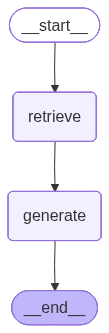

In [59]:
from IPython.display import display, Image

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
query = '연봉 5천만원인 직장인의 소득세는?'

initial_state = {'query': query}

graph.invoke(initial_state)

{'query': '연봉 5천만원인 직장인의 소득세는?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='1. 차입금의 상환기간이 15년 이상 장기주택저당차입금의 이자를 대봉정림으로 정하고 교정림(이하 이 항에서 “고정금리라 한다”)이라고 하며 차입금을 대봉정림으로 정한 경우에 비거주자 분당상환 방식으로 상환하는 경우: 2천만원\n  2. 차입금의 상환기간이 15년 이상 장기주택저당차입금의 이자를 고정금리로 지급하거나 그 차입금을 비거주자 분당상환으로 상환하는 경우: 1천800만원\n  3. 차입금의 상환기간이 10년 이상 장기주택저당차입금의 이자를 고정금리로 지급하거나 그 차입금을 비거주자 분당상환으로 상환하는 경우: 600만원\n  <삭제 2014. 1. 1.>\n제1항 및 제5항에 따른 공지는 해당 거주자가 대봉정림으로 정한 바에 따라 신청한 경우에 적용하며, 공개액이 거주자의 해당 각 기간의 합산소득금액을 초과하는 경우 그 초과하는 금액은 없는 것으로 한다.<개정 2014. 1. 1., 2014. 1.>\n<삭제 2014. 1. 1.>\n<삭제 2014. 1. 1.>\n제1항 및 제5항에 따른 공지는 “특별소득공제”란 한다.<개정 2014. 1. 1.>\n특별소득공제에 관해서는 그 밖에 필요한 사항을 대봉정림으로 정한다.<개정 2014. 1. 1.>\n제53조(생재를 같이 하는 부양가족의 범위와 판단기준) 제50조에 규정된 생계를 같이 하는 부양가족의 주민등록표 상의 동거가족으로서 해당 거주자의 주소 또는 거소에 실질적으로 생계를 같이 하는 사람으로 판단한다. 단, 자치법령에 의한 경우는 그러하지 아니하다.\n  ① 거주자 또는 동거가족(친지부모; 입양자는 제외한다)에 취하, 질병의 양, 근무 또는 신자의 형 등의 본래의 주소 또는 거소에서 실질적으로 대봉정림으로 판단되는 사유에 해당할 경우에는 제1항의 세례를 같이 하는 사람으로 본다.\n  ②

In [ ]:
from langgraph.graph import START, END

sequence_graph_builder = StateGraph(AgentState).add_sequence([retrieve, generate])
# 해당 노드들을 순차 실행하는 그래프 빌더를 생성함.

sequence_graph_builder.add_edge(START, 'retrieve')
sequence_graph_builder.add_edge('generate', END)

In [ ]:
sequence_graph = sequence_graph_builder.compile()

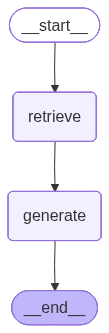

In [ ]:
from IPython.display import display, Image

display(Image(sequence_graph.get_graph().draw_mermaid_png()))